## Introduction
This is a script to identify users that are likely to spend money in their game after finishing the tutorial. Before start make sure to do the following steps: 

* Move all `*.db`, `*.parquet`, `*.csv` files to the `data` folder.
* Create a conda environment with using the `.yml` file using `conda env -n myenv create -f conda_env.yml`
* Activate your environment using `conda activate myenv` and run `jupyter notebook run_me.ipynb`

In order to make make this notebook cleaner, I prepared a python package called `amin_helper_package` in which some classes for data and model managements are implemented.


## Step1: Loading Data
The first step is to load users, users' actions and users' devices in different types (`.parquet`, `.db`, `.csv`) using the helper package.

In [1]:
DEBUG = True
import amin_helper_package as helper

df = helper.DataManager(users_path='./data/ka_users.csv',
                                  actions_path='./data/ka_actions.parquet',
                                  devices_path='./data/ka_devices.db',
                                  merge_on='uid_s').get_merged_data()

df = df.drop(columns=['uid_s', 'index'])

if DEBUG: 
    df = df.sample(frac=0.1)

print(df.shape)
df.describe()

(284593, 28)


,tz_i,local_time_join_hour,local_time_join_dow,total_spend,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i
count,284593.000000,284593.000000,284593.000000,284593.000000,284589.000000,175462.000000,1.749530e+05,208108.000000,208108.000000,208108.000000,208108.000000,283549.000000,284593.000000,284593.000000,284593.000000,284593.000000,284593.000000,284593.000000,284593.000000
mean,11097.222349,14.738296,4.211182,1.206161,2.958252,0.997099,1.746181e+09,886.483033,441.372249,127.834567,80.155708,130.383923,132.878040,2666.734769,817.717484,2699.674103,817.717484,5.807891,890.306125
std,19263.641693,5.676924,2.302323,13.702849,2.731992,0.053782,3.814653e+09,2439.746412,578.777300,564.734165,515.246840,228.719851,95.593471,1398.603633,473.861790,1399.758422,473.861790,2.427146,255.256959
min,-39600.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.390000e+08,11.000000,0.000000,0.000000,0.000000,1.000000,3.000000,399.000000,128.000000,448.000000,128.000000,1.000000,240.000000
25%,-10800.000000,11.000000,2.000000,0.000000,2.000000,1.000000,5.080000e+08,90.000000,80.000000,0.000000,0.000000,25.000000,69.000000,1823.000000,512.000000,1856.000000,512.000000,4.000000,720.000000
50%,19800.000000,16.000000,4.000000,0.000000,2.000000,1.000000,6.370000e+08,313.000000,309.000000,0.000000,0.000000,53.000000,128.000000,2756.000000,1024.000000,2816.000000,1024.000000,8.000000,800.000000
75%,28800.000000,19.000000,6.000000,0.000000,3.000000,1.000000,9.440000e+08,776.000000,595.000000,0.000000,0.000000,133.000000,166.000000,3595.000000,1024.000000,3648.000000,1024.000000,8.000000,1080.000000
max,39600.000000,23.000000,7.000000,405.000000,879.000000,1.000000,2.880000e+10,139131.000000,36952.000000,24714.000000,29917.000000,6341.000000,10720.000000,11524.000000,4096.000000,11584.000000,4096.000000,16.000000,2560.000000


## Step2: Exploratory Data Analysis

In [2]:
# Loading other libraries
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Firstly, to handle the missing values, we can see that most of the missing values come from users' behaviours and action database
print(df.isnull().sum())

# It is valuable to keep the data as much as possible. To fill the NaN values in actions, 
#let's fill with the minimum values (not mean because it's safer to consider a user made no action at all than having the average activity)
high_missing_columns = ['game_stats_tutorial_complete', 
                        'game_stats_tutorial_complete_time', 
                        'game_stats_xp',
                        'game_stats_xp1',
                        'game_stats_xp2',
                        'game_stats_xp3',
                        'redeemer_actions'
                       ]
for missing_column in tqdm(high_missing_columns, desc='Filling the missing values'):
    min_value = df[missing_column].min()
    df[missing_column].fillna(min_value, inplace = True)
    
# The remaining NaN values are not that much, so let's remove them    
df = df.dropna()

lang_s                                    0
geo_s                                    18
region_s                                  0
tz_i                                      0
local_time_join_hour                      0
local_time_join_dow                       0
total_spend                               0
logins                                    4
game_stats_tutorial_complete         109131
game_stats_tutorial_complete_time    109640
game_stats_xp                         76485
game_stats_xp1                        76485
game_stats_xp2                        76485
game_stats_xp3                        76485
redeemer_actions                       1044
scribe_actions                            0
platform_s                                0
device_mapped_s                           0
device_manufacturer_s                     0
device_mem_i                              0
device_gmem_i                             0
device_mem_grouping_i                     0
device_gmem_grouping_i          

Filling the missing values: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 113.93it/s]


In order to handle categorical features, let's use the `rearrange_categorical_features()` in the helper package. For more details, please see the code. The basic idea is to convert some of them to encode target labels with value between 0 and `n_classes-1`. For mobile devices, it doesn't make sense to store a long string for each device separately (`'device_os_s'`). So instead, let's keep track of Android devices with label `0` and iPhone devices with label `1`. Other information we extract from `device_os_s` is to see how updated the operating system is. Since iOS and Android versions are following different numbers, assign a float number to the version of the operating system between `[0-1]`. To get this feature, we can convert the version to a float number divided by the maximum version seen in those types of devices. For example, if we have a maximum iOS version 15, a device `iOS os: 10.1.0` will be mapped to `(1, 0.677)`.

In [4]:
# Handling categorical features
# First, let's remove some unnecessary features. In platform, the version of the operating system
df = helper.fe.rearrange_categorial_features(df)

Removing categorical features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]


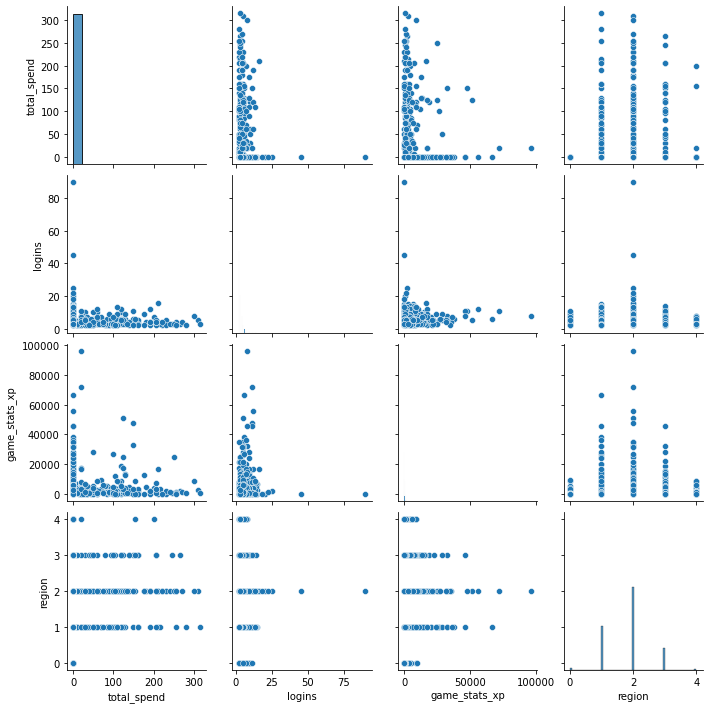

In [5]:
# plot the pair plot of some columns in data dataframe.
# Notes to observe from this pairplot: 
# Some columns like region is not balanced, we have lots of users from Asia 
sns.pairplot(data = df.sample(frac=0.05), vars=['total_spend','logins','game_stats_xp', 'region'])
plt.show()

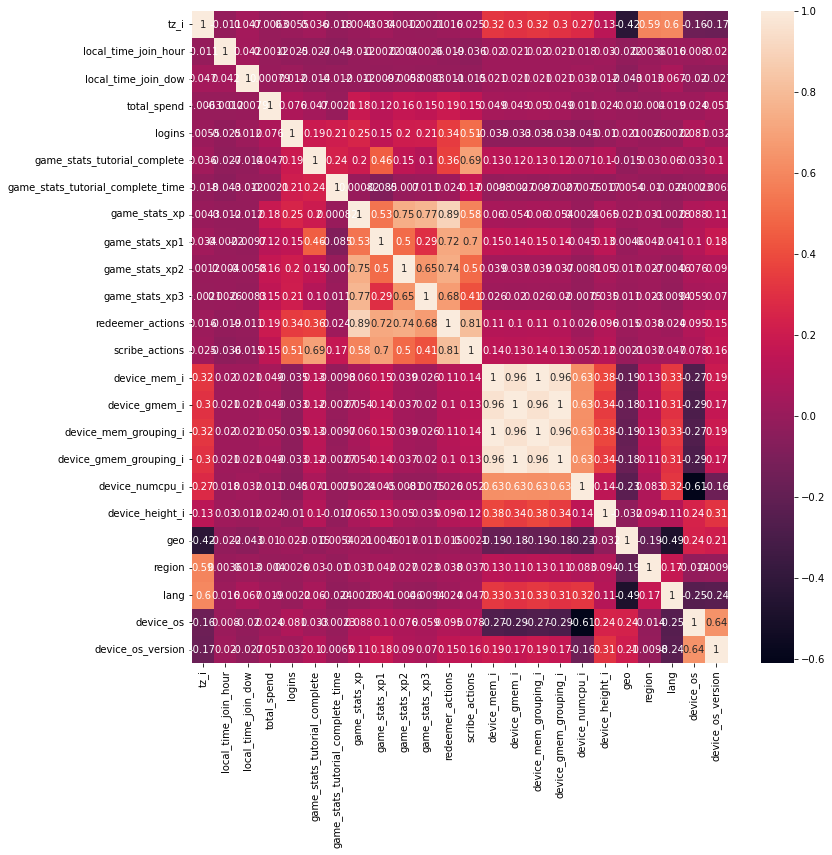

In [6]:
# To find what columns are correlated, lets create the 2D matrix of correlations
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.sample(frac=0.05).corr(), annot=True, ax=ax)
plt.show()

Correlated features in general don't improve models, and also it is always better to make the model simpler. Let's remove highly correlated features: 

In [7]:
feature_remove_list = [
    'device_gmem_i', 'device_mem_grouping_i', 'device_gmem_grouping_i', 
    'logins', 'redeemer_actions', 'game_stats_xp'
]
df = df.drop(columns = feature_remove_list)

## Step3: Preparing training/test sets

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

all_features = list(df.columns)

# Normalize all columns:
scaler = MinMaxScaler()
df[all_features] = scaler.fit_transform(df)

target = 'total_spend'
features = list(df.columns)
features.remove(target)

df, df_test = train_test_split(df, test_size=0.2, shuffle=True)


## Model1: RandomForest

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Evaluate the training set


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished


Error: 0.00
F1 score: 0.37


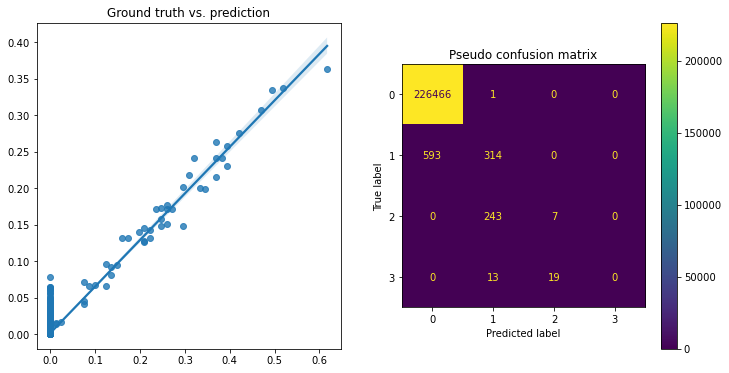

Evaluate the test set


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


Error: 0.01
F1 score: 0.20


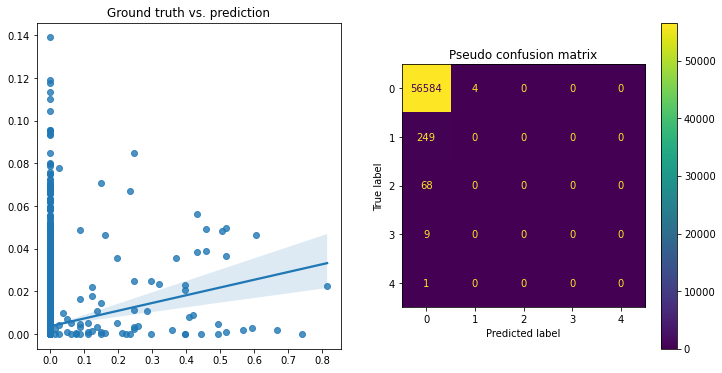

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

model1 = RandomForestRegressor(max_depth=25, 
                               n_estimators=100,
                               verbose=True)
model1.fit(df[features].values, df[target].values)

print('Evaluate the training set')
y_hat = model1.predict(df[features].values)
helper.model_eval.evaluate(df[target].values, y_hat, n_classes=3)
helper.model_eval.evaluate_plots(df[target].values, y_hat, n_classes=3)

print('Evaluate the test set')
y_hat = model1.predict(df_test[features].values)
helper.model_eval.evaluate(df_test[target].values, y_hat, n_classes=3)
helper.model_eval.evaluate_plots(df_test[target].values, y_hat, n_classes=3)

In [ ]:
df.shape